In [10]:
import os
import glob
import _pickle as c_pickle
import dlib
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# INÍCIO DO TREINAMENTO DO MODELO PARA CLASSIFICAR RONALD REAGAN E NANCY REAGAN

In [4]:
detector_face = dlib.get_frontal_face_detector()
detector_pontos = dlib.shape_predictor("/content/drive/MyDrive/facial_recog/resources/shape_predictor_68_face_landmarks.dat")
reconhecimento_facial = dlib.face_recognition_model_v1("/content/drive/MyDrive/facial_recog/resources/dlib_face_recognition_resnet_model_v1.dat")

In [5]:
indice = {}
idx = 0
descritores_faciais = None

In [6]:
for arquivo in glob.glob(os.path.join("/content/drive/MyDrive/facial_recog/photos/train", "*.jpg")):
    imagem = cv2.imread(arquivo)
    faces_detectadas = detector_face(imagem, 1)
    numero_faces_detectadas = len(faces_detectadas)

    if numero_faces_detectadas > 1:
        print(f"existem mais de uma face no arquivo. Arquivo - {arquivo}")
        exit(0)
    elif numero_faces_detectadas < 1:
        print(f"nenhuma face detectada no arquivo. Arquivo - {arquivo}")
        exit(0)

    for face in faces_detectadas:
        pontos_faciais = detector_pontos(imagem, face)
        descritor_facial = reconhecimento_facial.compute_face_descriptor(imagem, pontos_faciais)

        lista_descritor_facial = [df for df in descritor_facial]

        np_array_descritor_facial = np.asarray(lista_descritor_facial, dtype=np.float64)

        np_array_descritor_facial = np_array_descritor_facial[np.newaxis, :]

        if descritores_faciais is None:
            descritores_faciais = np_array_descritor_facial
        else:
            descritores_faciais = np.concatenate((descritores_faciais, np_array_descritor_facial), axis=0)

        indice[idx] = arquivo
        idx += 1

In [7]:
np.save("/content/validated_data/descritores_rn.npy", descritores_faciais)
with open("/content/validated_data/indices_rn.pickle", 'wb') as _file:
    c_pickle.dump(indice, _file)

# VALIDAÇÃO DO TREINO

In [8]:
detector_face = dlib.get_frontal_face_detector()
detector_pontos = dlib.shape_predictor("/content/drive/MyDrive/facial_recog/resources/shape_predictor_68_face_landmarks.dat")
reconhecimento_facial = dlib.face_recognition_model_v1("/content/drive/MyDrive/facial_recog/resources/dlib_face_recognition_resnet_model_v1.dat")
indices = np.load("/content/validated_data/indices_rn.pickle", allow_pickle=True)
descritores_faciais = np.load("/content/validated_data/descritores_rn.npy")
limiar = 0.5

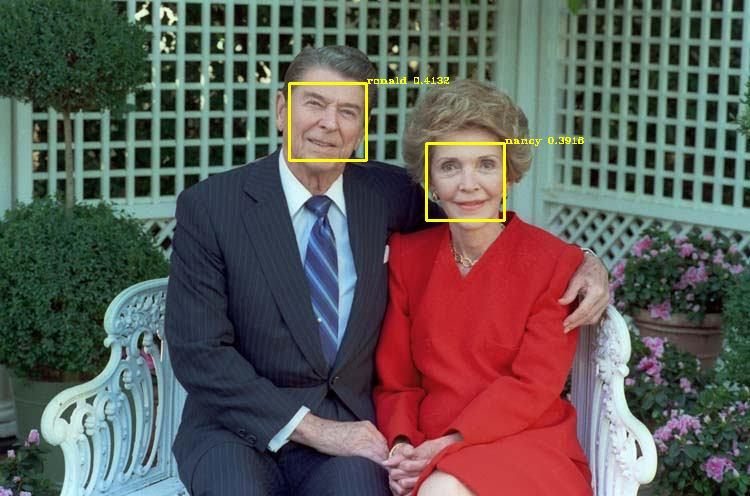

In [14]:
for arquivo in glob.glob(os.path.join("/content/drive/MyDrive/facial_recog/photos", "grupo.3.jpg")):
    imagem = cv2.imread(arquivo)
    faces_detectadas = detector_face(imagem, 2)
    for face in faces_detectadas:
        esquerda = int(face.left())
        topo = int(face.top())
        direita = int(face.right())
        baixo = int(face.bottom())

        pontos_faciais = detector_pontos(imagem, face)
        descritor_facial = reconhecimento_facial.compute_face_descriptor(imagem, pontos_faciais)
        lista_descritor_facial = [fd for fd in descritor_facial]

        np_array_descritor_facial = np.asarray(lista_descritor_facial, dtype=np.float64)
        np_array_descritor_facial = np_array_descritor_facial[np.newaxis, :]

        distancias = np.linalg.norm(np_array_descritor_facial - descritores_faciais, axis=1)
        minimo = np.argmin(distancias)
        distancia_minima = distancias[minimo]

        if distancia_minima <= limiar:
            nome = os.path.split(indices[minimo])[1].split(".")[0]
        else:
            nome = ' '

        cv2.rectangle(imagem, (esquerda, topo), (direita, baixo), (0, 255, 255), 2)
        texto = f"{nome} {distancia_minima:.4f}"
        cv2.putText(imagem, texto, (direita, topo), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (0, 255, 255))

    cv2_imshow(imagem)